# `BUILDING A ML MODEL TO PREDICT CUSTOMER CHURN` 
#### Using the CRISP-DM framework

## `Business Understanding`

#### Goal/Description
To create a machine learning model to predict the likelihood of retaining a customer

#### `Null Hypothesis`
There is no relationship between a tech savy customer and the customer retention

#### `Alternate Hypothesis`
There is a relationship between a tech savy customer and the customer retention

#### `Probing Questions`
- Do TV streaming customers have a higher monthly charge?
- What is the effect of online security and protection on customer retention?
- What is the relationship between customer age and the type of contract used?
- Do customers with dependents have more internet security?

## Data Understanding

#### Data Source
The data was sourced from a Telecommunication company and divided into three (3) parts :
- 3000 rows as the training data
- 2000 rows as the evaluation data 
- 2000 rows as the test data 

### Issues
- Some columns had multiple adjectives of the same word. eg no,no internet service,false 

#### Data Exploration

In [43]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import collections
import numpy as np

from sklearn.model_selection import * #train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import *
from sklearn.model_selection import * 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [44]:
#Access protocols for the SQL Database
env_variables= dotenv_values('logins.env')
database= env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [45]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [46]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM LP2_Telco_churn_first_3000"

sql_df= pd.read_sql(query, connection)
sql_df.info()

C:\Users\chrap\AppData\Local\Temp\ipykernel_4568\2011694408.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [47]:
# Describing the Dataframe
sql_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,3000,3000,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3000,2,Male,1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,3000,2,False,2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,3000,2,False,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,3000,2,False,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,3000.0,NaN,NaN,NaN,32.527333,24.637768,0.0,9.0,29.0,56.0,72.0
PhoneService,3000,2,True,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2731,2,False,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,3000,3,Fiber optic,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2349,2,False,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
##Accessing the second set of data 
csv_df = pd.read_csv("data\\LP2_Telco-churn-second-2000.csv")
csv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [49]:
# Describing the Dataframe
csv_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2043,2043,5600-PDUJF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2043,2,Male,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2043.0,NaN,NaN,NaN,0.16838,0.374295,0.0,0.0,0.0,0.0,1.0
Partner,2043,2,No,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2043,2,No,1412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2043.0,NaN,NaN,NaN,32.649046,24.376248,0.0,9.0,30.0,55.0,72.0
PhoneService,2043,2,Yes,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2043,3,No,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2043,3,Fiber optic,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2043,3,No,1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### OBSERVATIONS
- The dataset has a good gender balance of 51% of male and the rest being females.
- 84% of the customers are young which is expected as the younger generation are more aligned to streaming services.
- 80% are single individuals with no families.
- 

In [50]:
com_df=pd.concat([sql_df,csv_df],ignore_index=True)
com_df.head(5)
com_df.shape

(5043, 21)

In [51]:
#Checking the datatypes of the columns
datatypes = com_df.dtypes
datatypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [52]:
#Converting TotalCharges column to numeric
com_df['TotalCharges'] = pd.to_numeric(com_df['TotalCharges'], errors='coerce')
com_df=com_df.reset_index()

In [53]:
# Checking the Null value
com_df.isnull().sum()

index                 0
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [54]:
com_df.head(5)

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [55]:
#Dropping the index column
com_df = com_df.drop(['index'], axis=1)

In [56]:
com_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [57]:
com_df.replace(['No','No internet service','false','No phone service'], "False", inplace=True)
com_df.replace('Yes', "True", inplace=True)
com_df['SeniorCitizen'] = np.where(com_df['SeniorCitizen'] == 1, True, False)
com_df.InternetService.replace('false','None')

0               DSL
1               DSL
2               DSL
3               DSL
4       Fiber optic
           ...     
5038            DSL
5039    Fiber optic
5040            DSL
5041    Fiber optic
5042    Fiber optic
Name: InternetService, Length: 5043, dtype: object

In [58]:
com_df.replace({'True': True, 'False': False}, inplace=True)

C:\Users\chrap\AppData\Local\Temp\ipykernel_4568\739084101.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### Univariate Analysis

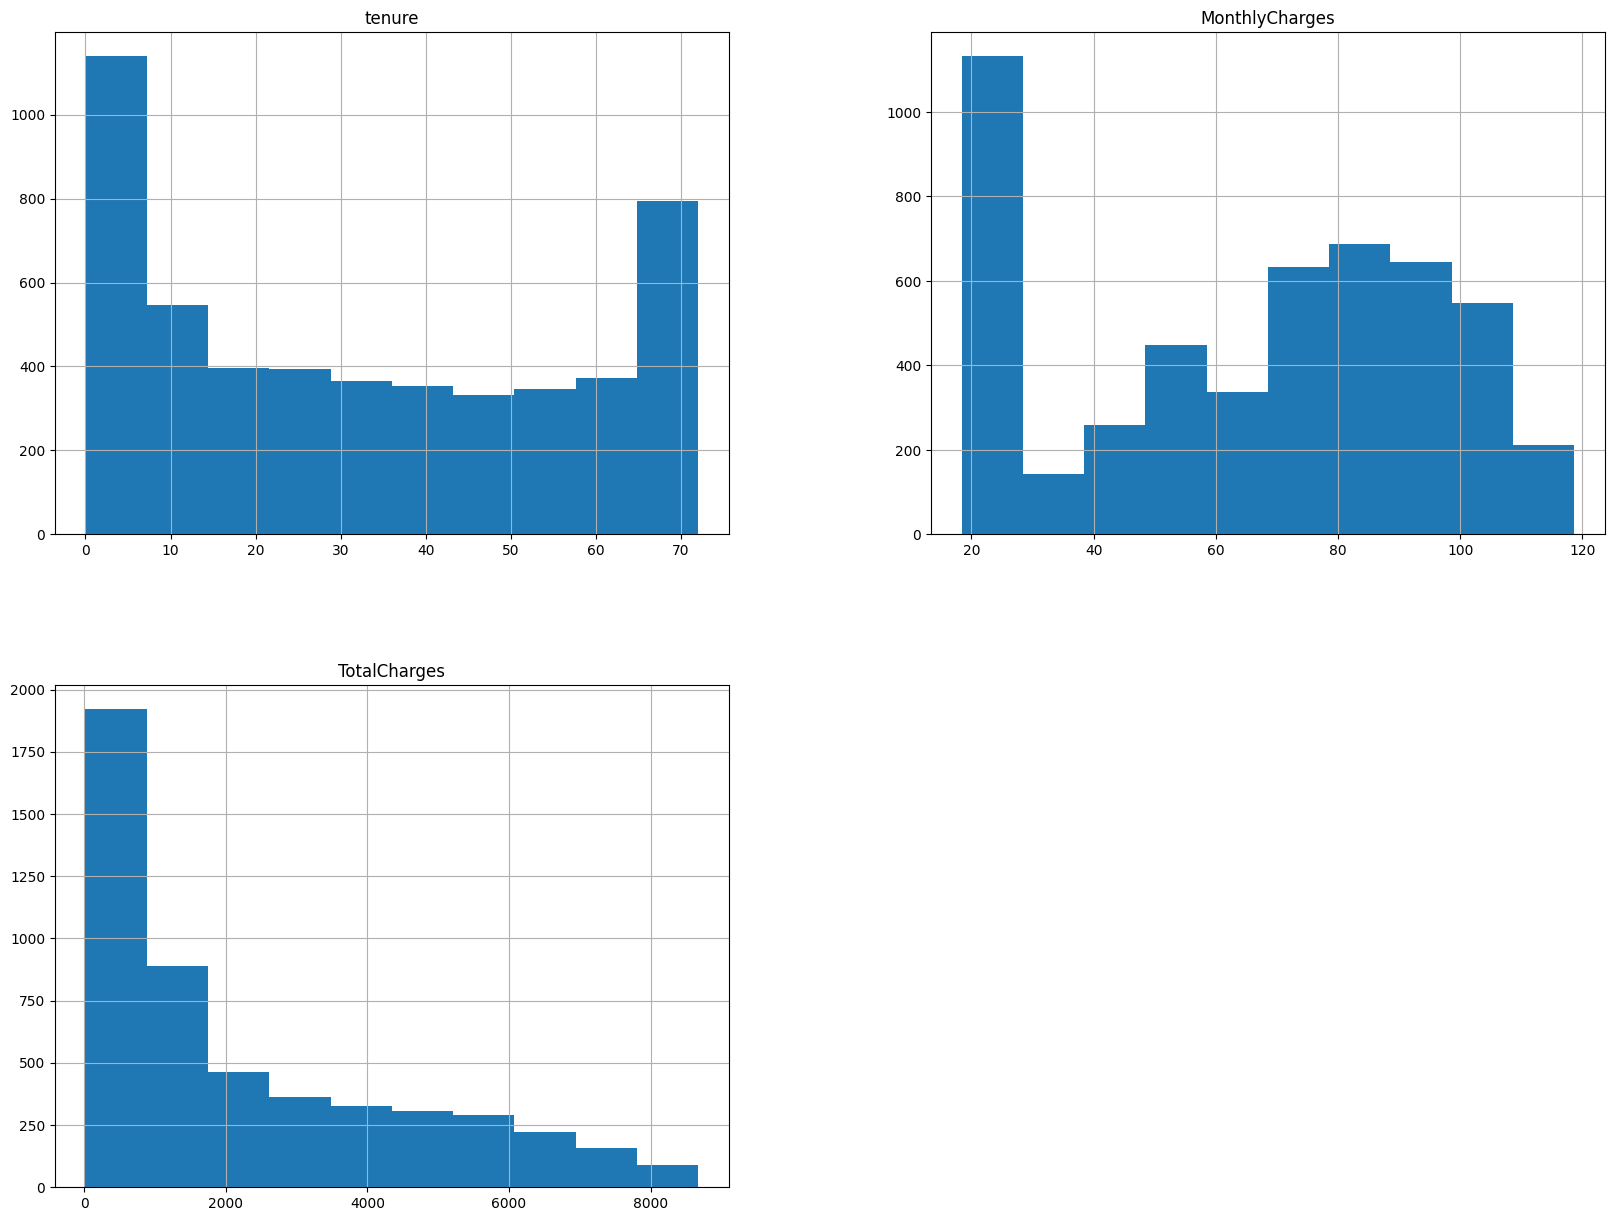

In [59]:
# Distribution of the variables
com_df.hist(figsize=(20, 15))
plt.show()

In [60]:
# Visualize the distribution of categorical columns
categoricals = [column for column in com_df.columns if com_df[column].dtype == "O"]
for column in categoricals:
        if column not in ['customerID']:
                fig = px.histogram(com_df, x=com_df[column], text_auto=True,color=column,
                               title=f"Distribution of customers based on {column}")
               
                fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45)
                fig.show()


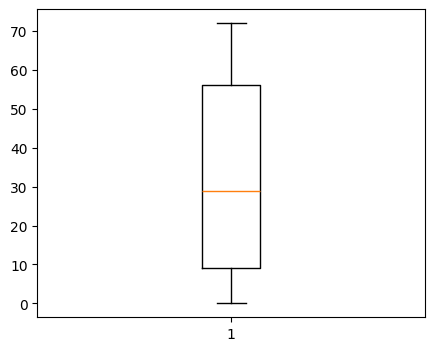

In [61]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(com_df.tenure)
plt.show()

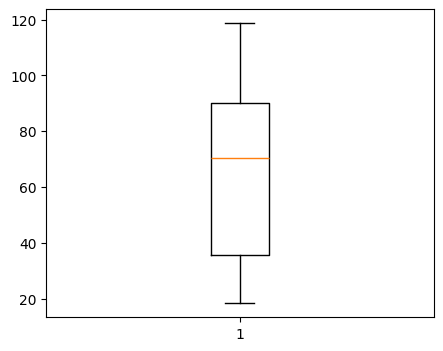

In [62]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(com_df.MonthlyCharges)
plt.show()

### Bivariate Analysis

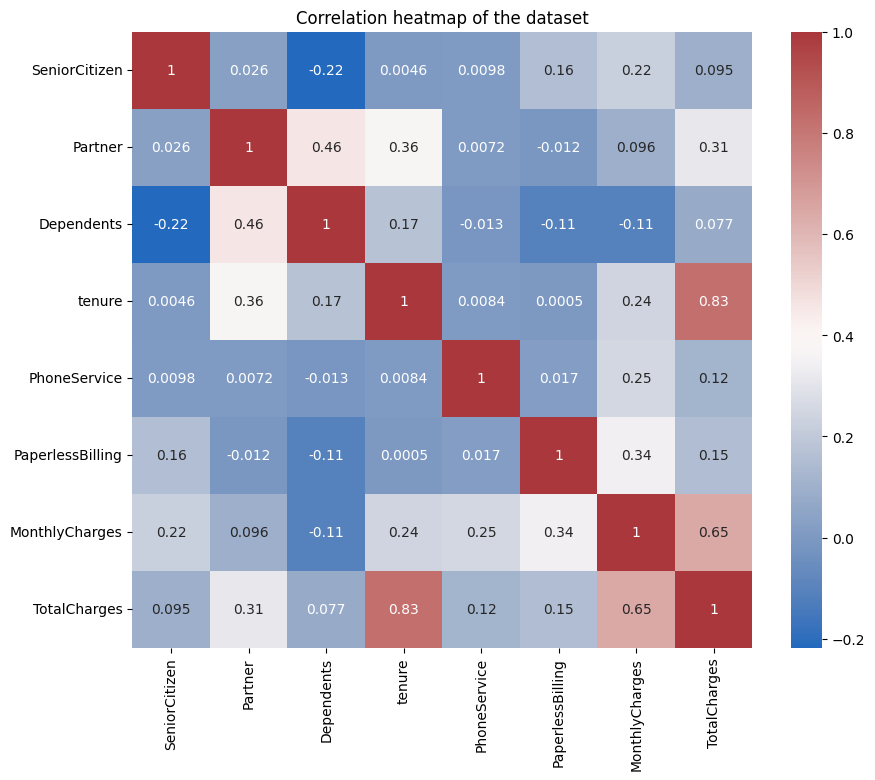

In [63]:
# Summarizing the relationships between the variables with a heatmap of the correlations
correlation_matrix = com_df.corr(numeric_only= True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag')
plt.title("Correlation heatmap of the dataset")
plt.show()

 # Answering the Analytical Questions


C:\Users\chrap\AppData\Local\Temp\ipykernel_4568\182800114.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='tenure Group,Churn'>

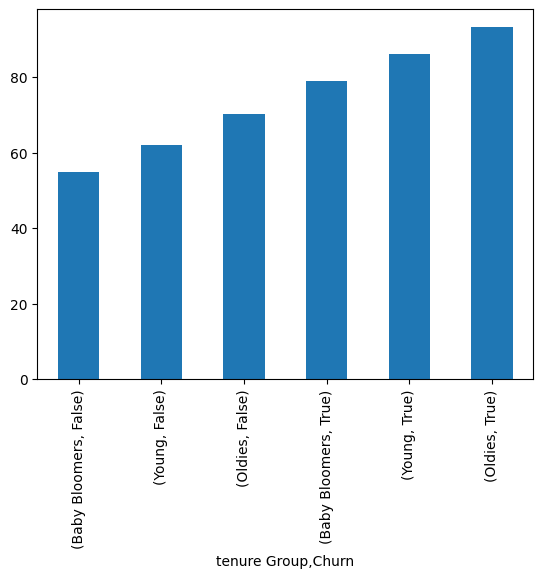

In [64]:
#How does tenure and monthly charge affect customer churn?

bins = [ 10, 30, 50,70]
df=com_df
labels = ['Baby Bloomers', 'Young', 'Oldies']
df['tenure Group'] = pd.cut(df['tenure'], bins=bins, labels=labels)
streamers = com_df.groupby(['tenure Group','Churn'])['MonthlyCharges'].mean().sort_values(ascending=True)
streamers.plot(kind='bar')

<Axes: xlabel='OnlineSecurity,DeviceProtection'>

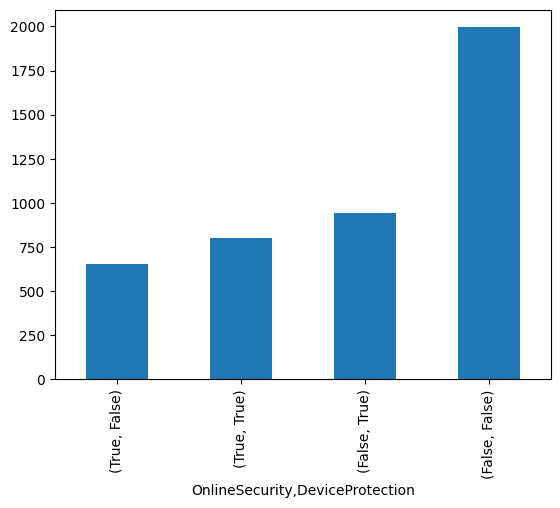

In [65]:
#What is the likelihood of a customer with online security and protection to churn?
cust_retention = com_df.groupby(['OnlineSecurity','DeviceProtection'])['Churn'].count().sort_values(ascending=True)
cust_retention.plot(kind='bar')

<Axes: xlabel='Contract'>

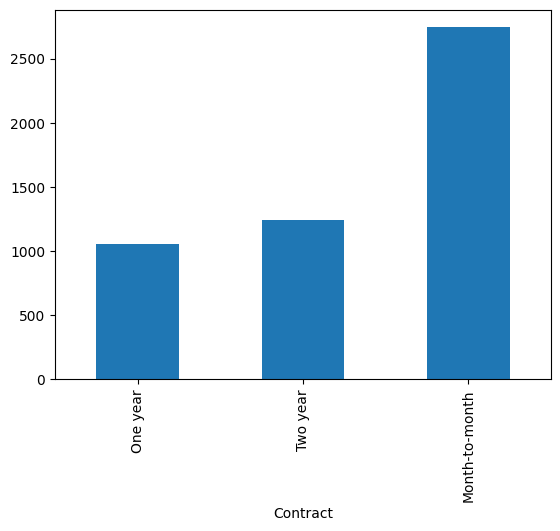

In [66]:
#What is the relationship between the type of contract and the likelihood of a customer churn?
cust_contract = com_df.groupby('Contract')['Churn'].count().sort_values(ascending=True)
cust_contract.plot(kind='bar')

OnlineSecurity  Dependents
True            True           541
False           True           743
True            False          914
False           False         2193
Name: Churn, dtype: int64

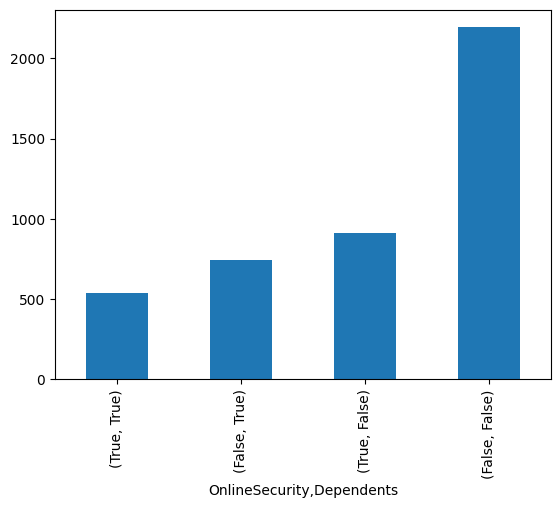

In [67]:
#Do customers with dependents and internet security likely to Churn?
cust_contract = com_df.groupby(['OnlineSecurity','Dependents'])['Churn'].count().sort_values(ascending=True)
cust_contract.plot(kind='bar')
cust_contract

In [68]:
#Dropping Empty rows
com_df = com_df.dropna(subset=['OnlineSecurity','OnlineBackup','DeviceProtection','MultipleLines','TotalCharges','Churn'],axis=0)

In [69]:
com_df.isnull().sum()


customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
tenure Group        1426
dtype: int64

In [70]:
#finding duplicates
duplicate = com_df[com_df.duplicated()]
duplicate.shape

(0, 22)

In [71]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.20f" % p_value_normality)
    if p_value_normality <0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [72]:
#Hypothesis
#There is no relationship between a tech savy customer and the customer retention
##
#
###
###
df_tech= com_df.loc[com_df.OnlineSecurity & com_df.DeviceProtection]
online=com_df.loc[com_df.OnlineSecurity]
device= com_df.loc[com_df.DeviceProtection]


device

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure Group
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False,Young
5,9305-CDSKC,Female,False,False,False,8,True,True,Fiber optic,False,...,False,True,True,Month-to-month,True,Electronic check,99.650002,820.500000,True,NaN
8,7892-POOKP,Female,False,True,False,28,True,True,Fiber optic,False,...,True,True,True,Month-to-month,True,Electronic check,104.800003,3046.050049,True,Baby Bloomers
12,8091-TTVAX,Male,False,True,False,58,True,True,Fiber optic,False,...,False,True,True,One year,False,Credit card (automatic),100.349998,5681.100098,False,Oldies
13,0280-XJGEX,Male,False,False,False,49,True,True,Fiber optic,False,...,False,True,True,Month-to-month,True,Bank transfer (automatic),103.699997,5036.299805,True,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5034,0639-TSIQW,Female,False,False,False,67,True,True,Fiber optic,True,...,False,True,False,Month-to-month,True,Credit card (automatic),102.950000,6886.250000,True,Oldies
5036,7750-EYXWZ,Female,False,False,False,12,False,False,DSL,False,...,True,True,True,One year,False,Electronic check,60.650000,743.300000,False,Baby Bloomers
5038,6840-RESVB,Male,False,True,True,24,True,True,DSL,True,...,True,True,True,One year,True,Mailed check,84.800000,1990.500000,False,Baby Bloomers
5039,2234-XADUH,Female,False,True,True,72,True,True,Fiber optic,False,...,False,True,True,One year,True,Credit card (automatic),103.200000,7362.900000,False,NaN


In [73]:
check_normality(df_tech.TotalCharges,'Online Security and Device Protection')
check_normality(online.TotalCharges,'Online Security')
check_normality(device.TotalCharges,'Device Protection')

p value:0.00000000001746254682
Reject null hypothesis >> The data for Online Security and Device Protection is not normally distributed
p value:0.00000000000000000142
Reject null hypothesis >> The data for Online Security is not normally distributed
p value:0.00000000000000000001
Reject null hypothesis >> The data for Device Protection is not normally distributed


In [74]:
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene= stats.levene(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges )

print("p value:%.10f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.0001300041
Reject null hypothesis >> The variances of the samples are different.


#### Observation 
-Data is not normally distributed
- Non-Parametric test can be done

In [75]:
#ANOVA test

stat, p = kruskal(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges)
print('Statistics=%.3f, p=%.15f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=84.496, p=0.000000000000000
One or more sample distributions are not equal distributions (reject null Hypothesis)


## Data preparation
### Selecting columns of interest for ML model
There columns of interest for the model are 
Dependents
InternetService
OnlineSecurity
OnlineBackup
TechSupport
StreamingTV
TechSupport
MonthlyCharges

In [76]:
df =com_df
df

In [99]:
df1=df.drop(columns=['customerID','OnlineSecurity','OnlineBackup','DeviceProtection','MultipleLines','TotalCharges'],axis=1)
df1.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,tenure Group
1,Male,False,False,False,34,True,DSL,False,False,False,One year,False,Mailed check,56.950001,False,Young


In [107]:
# Looking at the descriptive statistics of the columns with categorical values
cats = [column for column in com_df.columns if (com_df[column].dtype == "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
#cats.remove('tenure Group')           
cats.remove('customerID')
com_df[cats].describe()
cats=['SeniorCitizen','Partner','PhoneService']

Summary table of the Descriptive Statistics of Columns with Numeric Values


In [108]:
# Looking at the descriptive statistics of the columns with numeric values
numerics = [column for column in com_df.columns if (com_df[column].dtype != "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
com_df[numerics].describe()
numerics=['tenure','MonthlyCharges']

Summary table of the Descriptive Statistics of Columns with Numeric Values


In [113]:
target='Churn'
#used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1['tenure','MonthlyCharges']
y=df1['Churn']


KeyError: ('tenure', 'MonthlyCharges')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# making pipeline
scaler = MinMaxScaler()
encoder = OneHotEncoder()
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, numerics),
                    ('cat', cat_transformer, cats)])


In [106]:
# choosing model
model_name = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# giving all values to pipeline
pipe = make_pipeline(preprocessor,model_name)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

ValueError: A given column is not a column of the dataframe

In [77]:
#df['Column1'] = df['Column1'].astype(str)

### Feature Correlation and Selection

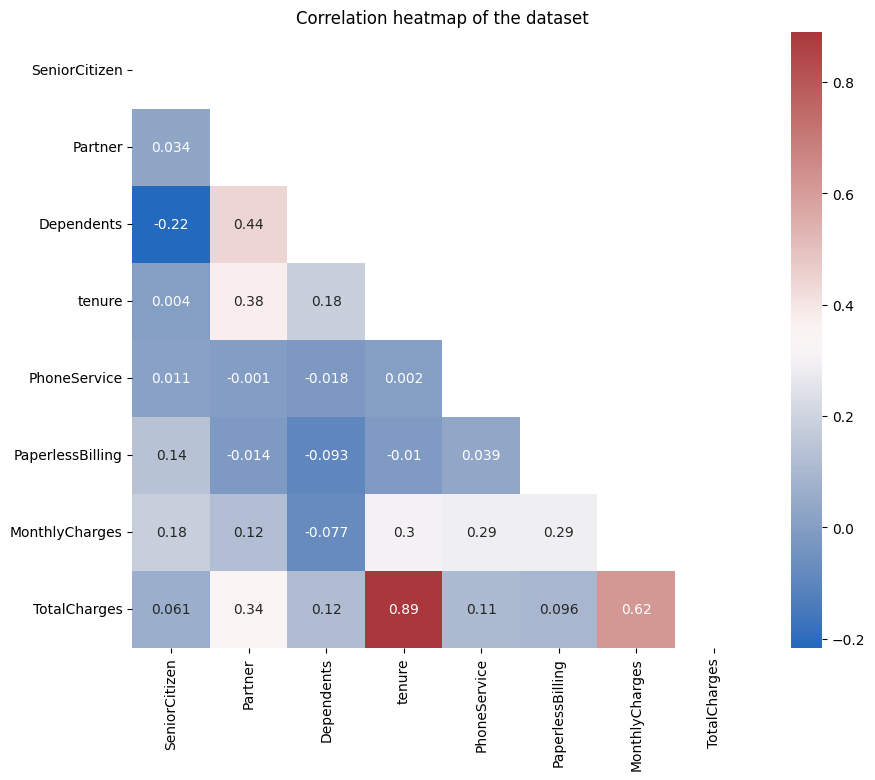

In [78]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = com_df.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

### Observation
Gives a better visualization of the correlation heat map and the columns of interest can be easily selected

Summary table of the Descriptive Statistics of Columns with Numeric Values


,tenure,MonthlyCharges,TotalCharges
count,4118.000000,4118.000000,4118.000000
mean,32.853813,73.520435,2607.558100
std,24.534154,26.210337,2360.549883
min,1.000000,18.550000,18.850000
25%,9.000000,55.762500,520.962500
50%,30.000000,78.950000,1828.399988
75%,56.000000,94.199997,4434.700049
max,72.000000,118.650002,8670.100000


Summary table of the Descriptive Statistics of Columns with Numeric Values


,gender,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,Churn
count,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118
unique,2,2,3,2,2,2,2,2,2,3,4,2
top,Male,False,Fiber optic,False,False,False,False,False,False,Month-to-month,Electronic check,False
freq,2074,2148,2247,2781,2507,2491,2745,2285,2263,2381,1543,2886


In [81]:
from sklearn.pipeline import make_pipeline

target='Churn'
used_cols = [c for c in cats if c not in [target]]
X=com_df[used_cols]
y=df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling and Evaluation


##  Training and Evaluating on the Training Set

In [82]:
# Defining the target & predictor variables
X = com_df.drop(columns=["Churn",'customerID'])
y =com_df["Churn"]
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure Group
1,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,Young
2,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,NaN
4,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,NaN
5,Female,False,False,False,8,True,True,Fiber optic,False,False,True,False,True,True,Month-to-month,True,Electronic check,99.650002,820.500000,NaN
6,Male,False,False,True,22,True,True,Fiber optic,False,True,False,False,True,False,Month-to-month,True,Credit card (automatic),89.099998,1949.400024,Baby Bloomers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Male,False,True,True,24,True,True,DSL,True,False,True,True,True,True,One year,True,Mailed check,84.800000,1990.500000,Baby Bloomers
5039,Female,False,True,True,72,True,True,Fiber optic,False,True,True,False,True,True,One year,True,Credit card (automatic),103.200000,7362.900000,NaN
5040,Female,False,True,True,11,False,False,DSL,True,False,False,False,False,False,Month-to-month,True,Electronic check,29.600000,346.450000,Baby Bloomers
5041,Male,True,True,False,4,True,True,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Mailed check,74.400000,306.600000,NaN


In [83]:

# Splitting the dataframe into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state=27)


In [84]:
X_train[numerics]#.info()


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,tenure Group
3424,True,True,False,65,True,True,92.700000,5968.400000,Oldies
422,False,False,True,29,True,False,100.550003,2830.449951,Baby Bloomers
4852,False,True,True,44,True,True,61.900000,2924.050000,Young
1643,False,True,False,37,True,True,90.349998,3419.300049,Young
1840,False,True,True,65,True,False,108.650002,6937.950195,Oldies
...,...,...,...,...,...,...,...,...,...
904,False,True,True,67,True,False,81.349998,5398.600098,Oldies
1459,False,False,False,60,True,True,99.650002,5941.049805,Oldies
3852,True,True,False,21,True,True,69.100000,1474.750000,Baby Bloomers
4837,True,False,False,6,True,True,79.700000,497.600000,NaN


In [85]:
# Scale the numeric columns
scaler = MinMaxScaler()
X_train[numerics] = scaler.fit_transform(X_train[numerics])
#X_test[numerics] = scaler.transform(X_test[numerics])

ValueError: Cannot cast object dtype to float64

In [ ]:
## Modeling

##K-NN,support vector machine,
#Sigmoid kernel, similar to logistic regression is used for binary classification under svm
y_train_slr= encoded_train_df[['Churn']]
y_test_slr= encoded_test_df[['Churn']]
encoded_train_df= encoded_train_df.drop(columns = ["Churn"])
encoded_test_df= encoded_test_df.drop(columns = ["Churn"])

# Building a Logistic Regression Model

In [ ]:
# We will be using a single Dependent Variable to build our Logistic Regression Model



len(encoded_train_df)


NameError: name 'encoded_train_df' is not defined

In [ ]:
len(y_train_slr)
y_train_slr

In [ ]:
len(encoded_train_df)

In [ ]:
y_train_slr['Churn'] = y_train_slr['Churn'].astype(bool)
y_test_slr['Churn'] = y_test_slr['Churn'].astype(bool)

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(encoded_train_df)
scaler.mean_
scaler.scale_

In [ ]:
x_trained_scaled = scaler.transform(encoded_train_df)
x_trained_scaled

In [ ]:
# Initializing the MLR model
slr = LogisticRegression(solver='liblinear',random_state=17)

#Fitting the SLR model to the Training Data
slr.fit(encoded_train_df,y_train_slr)

# Print the model's intercept
print(f'SLR intercept ---> {slr.intercept_}')

#The regression coefficients
print(f'SLR coefficents ---> {slr.coef_}')

## Evaluating the Accuracy of the SLR model
Using the Root Mean Squeared Method and the Mean Absolute Error to evaluate model

In [ ]:
y_train_pred

In [ ]:
from sklearn.metrics import r2_score

#Training Accuracy using R squarred
y_train_pred = slr.predict(encoded_train_df)

slr.score(y_train_slr, y_train_pred)


In [ ]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_train_slr, y_train_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cnf_matrix)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cnf_matrix[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
#Test Accuracy using the Test Data
y_test_pred = slr.predict(encoded_test_df)
#slr_rsqd_test = r2_score(y_test_slr, y_test_pred)

In [ ]:
y_test_pred

In [ ]:
print(f'Rsqd of Train Dataset is: {slr_rsqd_train*100:.2f}%\n\nRsqd of Test {slr_rsqd_test*100:.2f}%')

In [ ]:
## Evaluation

### Data Understainding

Data Understanding typically involves the following steps:

- Determine what data is needed and collect the data if not available
- Explore data
- Verify data quality

In [ ]:
# Distribution of the variables
data.hist(figsize=(20, 15))

### EDA 
#### Visualizing Characteristics of the Dataset

In [ ]:
monthly_charges=(data.groupby('PaymentMethod',sort=True)['TotalCharges'].sum())
fig=px.bar(monthly_charges,y='TotalCharges')#,color ='PaymentMethod',text='PaymentMethod',labels={'PaymentMethod':'Sum of charges(Lahks/1000)'})
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()